# Scrapbook

This notebook is used for development, its content can change at any time.

In [1]:
import timeatlas as ta
import pandas as pd

In [2]:
s = pd.read_csv("../data/bbdata/2902.csv")
s = pd.DataFrame(data=s["value"].values, index=pd.to_datetime(s["timestamp"]).values)
s.index = s.index.round("S")

In [3]:
ts = ta.TimeSeries(s)

In [10]:
ts.series

,values
2018-02-01 00:13:10,6.132
2018-02-01 00:28:10,4.971
2018-02-01 00:43:10,6.050
2018-02-01 00:58:10,6.056
2018-02-01 01:13:10,6.187
...,...
2018-02-01 22:58:05,6.065
2018-02-01 23:13:04,5.414
2018-02-01 23:28:04,5.707
2018-02-01 23:43:04,6.188


/Users/frederic.montet/.local/share/virtualenvs/timeatlas-6ip_oGBK/lib/python3.7/site-packages/pandas/plotting/_matplotlib/converter.py:245: MatplotlibDeprecationWarning: 
The epoch2num function was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
  base = dates.epoch2num(dt.asi8 / 1.0e9)


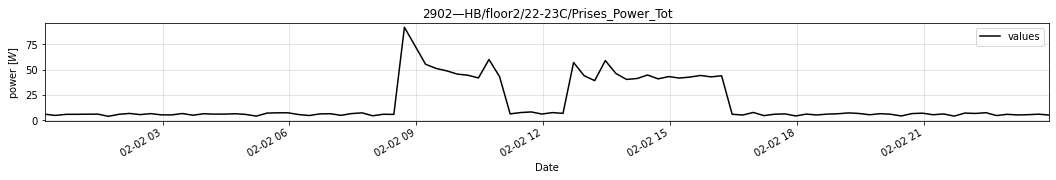

In [8]:
ts.plot()

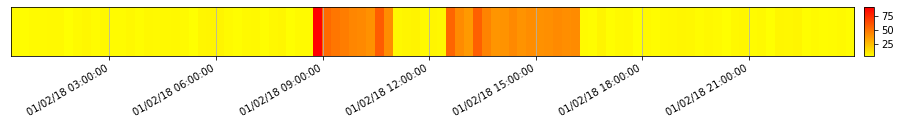

In [4]:
ta.plots.status(ts)

## Define a Metadata object

In [6]:
from timeatlas import Metadata, types

# You can use some typed metadata object
my_unit = types.Unit("power", "W", "float")
my_sensor = types.Sensor(2902, "HB/floor2/22-23C/Prises_Power_Tot")

# Or use Python dictionaries
my_location = {
    "building" : "Blue Factory",
    "floor" : "12",
    "room"  : "22C"
}
my_coordinates = {
    "lat" : 46.796611,
    "lon" : 7.147563
}
my_dict = {
    "unit": my_unit,
    "sensor": my_sensor,
    "location": my_location,
    "coordinates": my_coordinates
}

# Create the Metadata object
my_meta = Metadata(my_dict)


## Define a TimeSeries with Metadata

In [7]:
ts = ts.fill(np.random.randint(0,100,len(ts)))

In [7]:
ts.metadata = my_meta

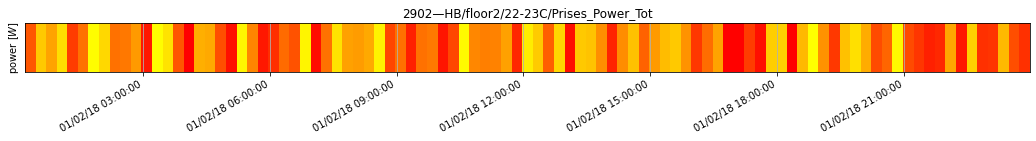

In [10]:
ta.plots.status(ts)

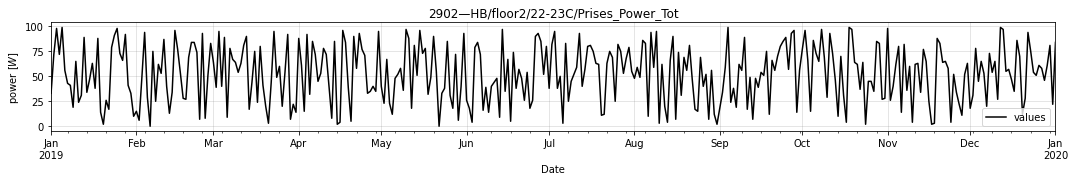

In [45]:
ts.plot()

## Make Predictions

Some definitions:

- `time series` : self-explanatory, i.e. the TimeSeries object
- `horizon` : the duration to predict after the last value of the time series
- `frequency`: the number of values per unit of time. Usually, the frequency is given in Pandas offset aliases (https://pandas.pydata.org/pandas-docs/stable/user_guide/timeseries.html#offset-aliases)

```
                                horizon
   |-------------------------|- - - - - -|
                             |||||||||||||
           time series         frequency

```

In [ ]:
from timeatlas import models

In [ ]:
m1 = models.Prophet()
m1.fit(ts_meta)
pts1 = m1.predict(ts_meta)
pts2 = m1.predict("24 hours")

In [ ]:
m2 = models.LinearRegression()
m2.fit(ts_meta)
pts3 = m2.predict(ts_meta)
pts4 = m2.predict("14 days")

In [ ]:
from timeatlas import plots

plots.prediction(ts_meta, pts1)

## Detect Anomalies


In [ ]:
from timeatlas import detectors, metrics

In [ ]:
ts.apply(lambda x: x+1).series.head()

In [ ]:
# Create the base of the detector. 
# i.e. this detector is based on this model and compute this error
d = detectors.Surprise(m1, metrics.relative_error)

# Set the alerts
d.alerts("quantile", [0.65, 0.8, 0.85, 0.95])\

# Fit the detector with a specific Time Series
d.fit(ts_meta)

In [ ]:
# Detect anomalies with the fitted detector
a = d.detect(ts2)

In [ ]:
a.plot()

In [ ]:
d.truth.plot()
d.prediction.plot()